In [1]:
%matplotlib inline
import csv
import matplotlib.pyplot as plt 
import os
import io
import requests
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler


In [2]:
def load_data(filename, inputs_variables_names,
              output_variable_name):
    data = []
    data_names = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                data_names = row
            else:
                data.append(row)
            line_count += 1

    selected_variables_index = [data_names.index(variable) for variable in inputs_variables_names]
    inputs = []
    for var in selected_variables_index:
        inputs.append([data[index][var] for index in range(len(data))])

    output_selected_index = data_names.index(output_variable_name)
    outputs = [data[index][output_selected_index] for index in range(len(data))]

    return inputs, outputs

In [3]:
excluded = []
def fromStringToNumericData(values,exc=[]):
    global excluded
    if isinstance(values[0], list):
        aux = []

        for i in range(len(values)):
            for j in range(len(values[i])):
                if(values[i][j]=="" or values[i][j]=="0"):
                    excluded.append(j)

        for i in range(len(values)):
            line = []
            for j in range(len(values[i])): 
                if((j not in excluded) and (j not in excluded)):
                    line.append(float(values[i][j]))
                    
            aux.append(line)

        return aux
    
    else:
        aux = []

        for i in range(len(values)):
            if (values[i]=="" or values[i]=="0"):
                excluded.append(i)
        for i in range(len(values)):
            if ((i not in excluded) and (i not in excluded)):
                aux.append(float(values[i]))

        return aux

In [4]:
def plot_histogram(x, name):
    plt.hist(x, 10)
    plt.title('Histogram of ' + name)
    plt.show()

def plot(ins, outs,in_name,out_name):
    print(ins[:5])
    print(outs[:5])

    plot_histogram(ins, in_name)
    plot_histogram(outs, out_name)

    plt.plot(ins, outs, 'ro')
    plt.xlabel(in_name)
    plt.ylabel(out_name)
    plt.show()

In [7]:
def plot3Ddata(x1, x2, y, x1Model = None, x2Model = None, yModel = None, x1Test = None, x2Test = None, yTest = None, title = None, featureName1=None, featureName2=None, outputName=None):
    #x1,x2,y = datele de input/output
    #x1Model,x2Model,yModel = "xref + yref" AKA _rezultatul_
    #x1Test,x2Test,yTest = date de input/output "pastrate" pentru testare
    
    ax = plt.axes(projection = '3d')

    if (x1):
        plt.scatter(x1, x2, y, c = 'r', marker = 'o', label = 'train data') 

    if (x1Model):
        plt.scatter(x1Model, x2Model, yModel, c = 'b', marker = '_', label = 'learnt model') 

    if (x1Test):
        plt.scatter(x1Test, x2Test, yTest, c = 'g', marker = '^', label = 'test data')  

    if(title):
        plt.title(title)
    else:
        plt.title(featureName1+" vs "+featureName2+" vs "+outputName)
    ax.set_xlabel(featureName1)
    ax.set_ylabel(featureName2)
    ax.set_zlabel(outputName)
    plt.legend()
    plt.show()
    

[1.61646318435669, 1.48238301277161, 1.480633020401, 1.56497955322266, 1.44357192516327]
[7.53700017929077, 7.52199983596802, 7.50400018692017, 7.49399995803833, 7.4689998626709]


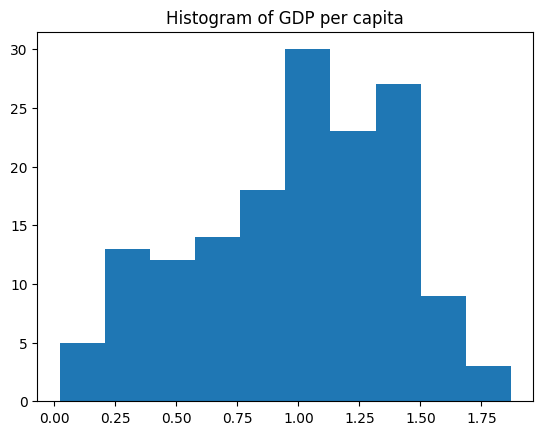

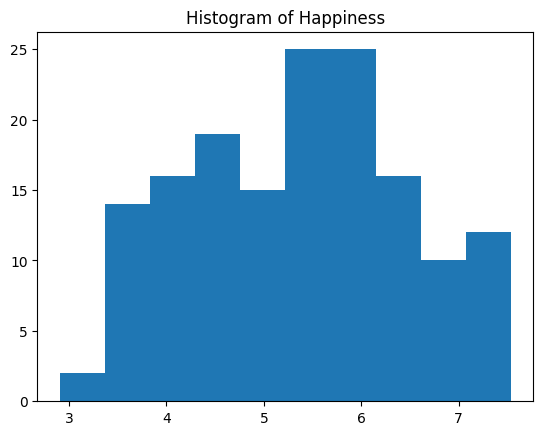

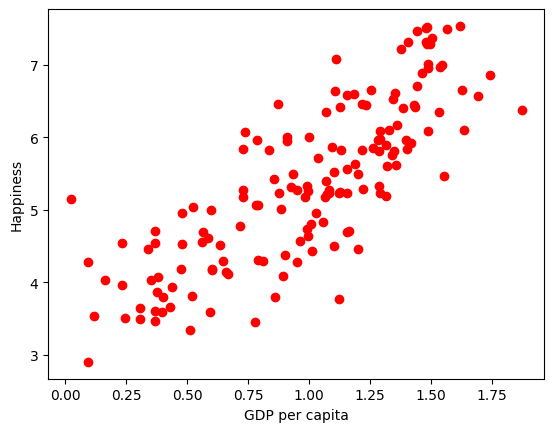

In [8]:
featureNames = ["Economy..GDP.per.Capita."]
outputName = "Happiness.Score"
fileName = "data/world-happiness-report-2017.csv"

inputs, outputs = load_data(fileName, featureNames, outputName)
inputs = fromStringToNumericData(inputs)
outputs = fromStringToNumericData(outputs)

plot(inputs[0],outputs,"GDP per capita","Happiness")

In [9]:
regressor = linear_model.SGDRegressor(alpha = 0.01,max_iter=100)

inputs2 = [[e1] for e1 in inputs[0]]

regressor.fit(inputs2,outputs)
w0,w1 = regressor.intercept_[0], regressor.coef_[0]
print('tool: f(x) = ', w0, '+', w1, '* x1')

tool: f(x) =  2.7970541418050896 + 2.546056264496625 * x1


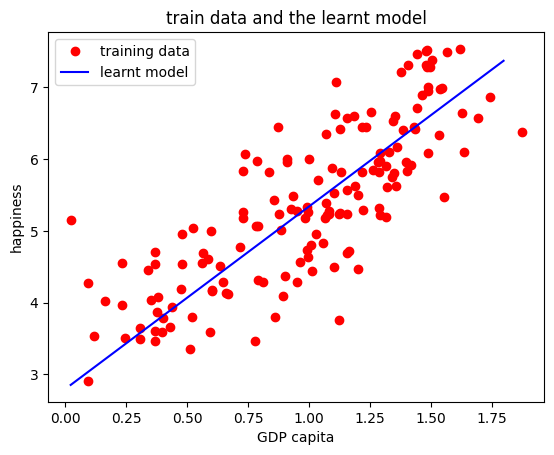

In [10]:
noOfPoints = 50
xref = []
val = min(inputs[0])
step = (max(inputs[0]) - min(inputs[0])) / noOfPoints
for i in range(1, noOfPoints):
    xref.append(val)
    val += step
yref = [w0 + w1 * el for el in xref] 

plt.plot(inputs2, outputs, 'ro', label = 'training data')  #train data are plotted by red and circle sign
plt.plot(xref, yref, 'b-', label = 'learnt model')                  #model is plotted by a blue line
plt.title('train data and the learnt model')
plt.xlabel('GDP capita')
plt.ylabel('happiness')
plt.legend()
plt.show()

In [11]:
def norm(features, mean_value=None, std_dev=None):
    if mean_value is None:
        mean_value = sum(features) / len(features)
    if std_dev is None:
        std_dev = (1 / len(features) * sum([(feat - mean_value) ** 2 for feat in features])) ** 0.5
    normalised_features = [(feat - mean_value) / std_dev for feat in features]
    return normalised_features, mean_value, std_dev

def norm_d(data):
    mean_value, std_dev = None, None
    normalised_data = []
    for dat in data:
        normalised_features, mean_value, std_dev = norm(dat, mean_value, std_dev)
        normalised_data.append(normalised_features)
    return normalised_data

def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        #encode each sample into a list
        trainData = [[d] for d in trainData]
        testData = [[d] for d in testData]
        
        scaler.fit(trainData)  #  fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
        
        #decode from list to raw values
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]

    else:
        scaler.fit(trainData)  #  fit only on training data
        normalisedTrainData = scaler.transform(trainData) # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data

    return normalisedTrainData, normalisedTestData

In [12]:
def impartire(inputs,outputs):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes  if not i in trainSample]

    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]

    #trainInputs, testInputs = normalisation(trainInputs, testInputs)
    #trainOutputs, testOutputs = normalisation(trainOutputs, testOutputs)

    return trainInputs,trainOutputs,testInputs,testOutputs

print(inputs2)
inTr,outTr,inTe,outTe = impartire(inputs2,outputs)

[[1.61646318435669], [1.48238301277161], [1.480633020401], [1.56497955322266], [1.44357192516327], [1.50394463539124], [1.47920441627502], [1.40570604801178], [1.49438726902008], [1.484414935112], [1.37538242340088], [1.10970628261566], [1.48709726333618], [1.54625928401947], [1.53570663928986], [1.48792338371277], [1.46378076076508], [1.74194359779358], [1.44163393974304], [1.25278460979462], [1.62634336948395], [1.10735321044922], [1.35268235206604], [1.18529546260834], [1.15318381786346], [1.69227766990662], [1.34327983856201], [1.21755969524384], [0.872001945972443], [1.23374843597412], [1.43092346191406], [1.12786877155304], [1.43362653255463], [1.38439786434174], [1.87076568603516], [1.07062232494354], [1.53062355518341], [1.36135590076447], [1.63295245170593], [1.32539355754852], [1.48841226100922], [1.29121541976929], [0.737299203872681], [1.00082039833069], [0.909784495830536], [1.29178786277771], [0.786441087722778], [1.39506661891937], [1.28177809715271], [0.907975316047668]

[1.61646318435669, 1.48238301277161, 1.480633020401, 1.56497955322266, 1.44357192516327]
[7.53700017929077, 7.52199983596802, 7.50400018692017, 7.49399995803833, 7.4689998626709]


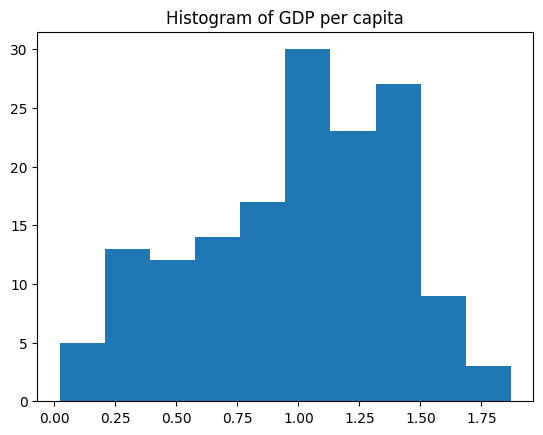

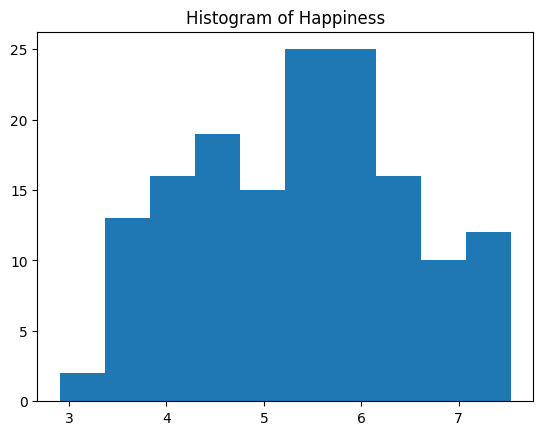

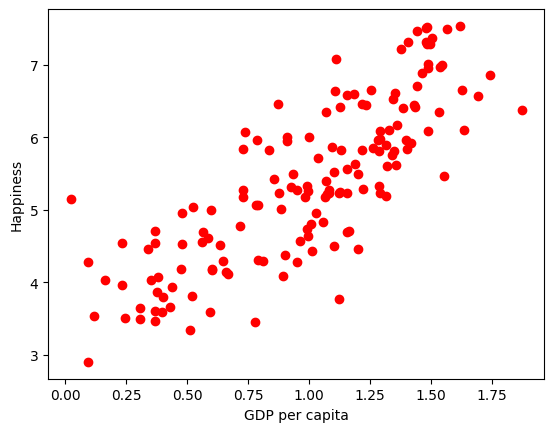

[0.635422587394714, 0.626006722450256, 0.627162635326385, 0.620070576667786, 0.617950856685638]
[7.53700017929077, 7.52199983596802, 7.50400018692017, 7.49399995803833, 7.4689998626709]


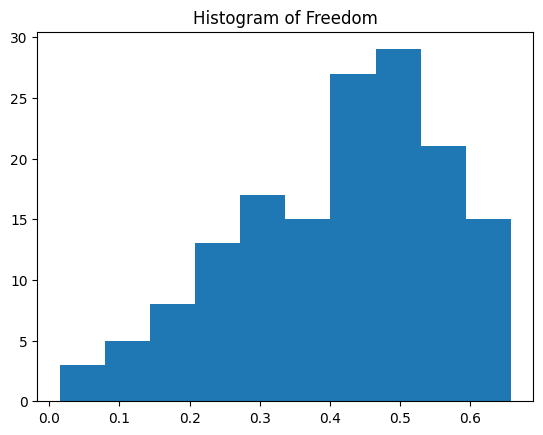

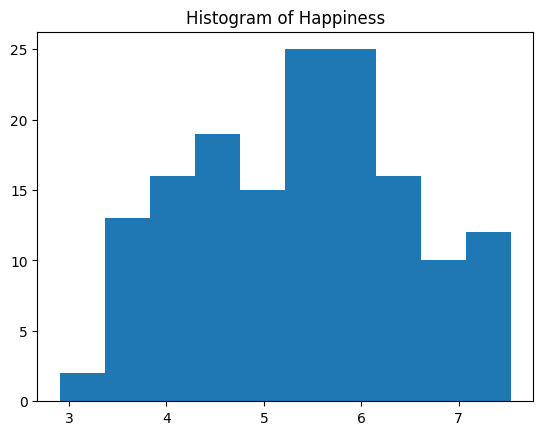

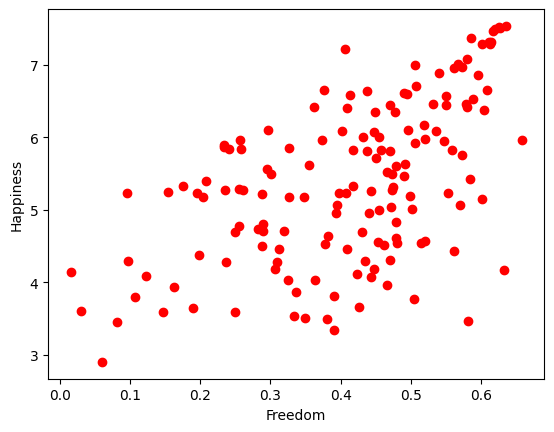

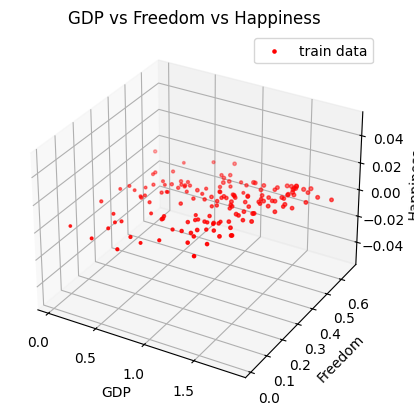

In [14]:
featureNames = ["Economy..GDP.per.Capita.","Freedom"]
outputName = "Happiness.Score"
fileName = "data/world-happiness-report-2017.csv"

inputs, outputs = load_data(fileName, featureNames, outputName)
inputs = fromStringToNumericData(inputs)
outputs = fromStringToNumericData(outputs)
plot(inputs[0],outputs,"GDP per capita","Happiness")
plot(inputs[1],outputs,"Freedom","Happiness")
plot3Ddata(inputs[0],inputs[1],outputs,featureName1="GDP",featureName2="Freedom",outputName="Happiness")

In [15]:
regressor = linear_model.SGDRegressor(alpha = 0.01,max_iter=100)

inputs2 = [[e1,e2] for e1,e2 in zip(inputs[0],inputs[1])]

regressor.fit(inputs2,outputs)
w0,w1,w2 = regressor.intercept_[0], regressor.coef_[0], regressor.coef_[1]
print('tool: f(x) = ', w0, '+', w1, '* x1 +', w2, '* x2')

tool: f(x) =  2.594138234521443 + 2.3153298044053865 * x1 + 1.1047482079250424 * x2


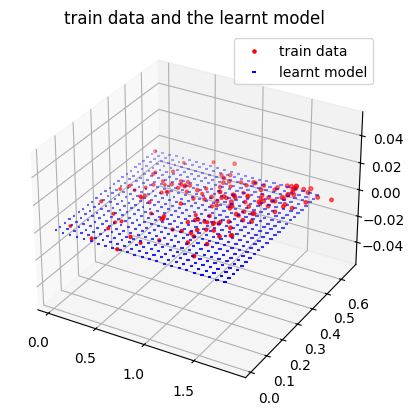

In [16]:
#numerical representation of the regressor model
noOfPoints = 25
xref1 = []
val = min(inputs[0])
step1 = (max(inputs[0]) - min(inputs[0])) / noOfPoints
for _ in range(1, noOfPoints):
    for _ in range(1, noOfPoints):
        xref1.append(val)
    val += step1

xref2 = []
val = min(inputs[1])
step2 = (max(inputs[1]) - min(inputs[1])) / noOfPoints
for _ in range(1, noOfPoints):
    aux = val
    for _ in range(1, noOfPoints):
        xref2.append(aux)
        aux += step2
yref = [w0 + w1 * el1 + w2 * el2 for el1, el2 in zip(xref1, xref2)]

plot3Ddata(inputs[0], inputs[1], outputs, xref1, xref2, yref, title='train data and the learnt model')

In [17]:
print(inputs)
normd = norm_d([*inputs,outputs])
print(normd)

normd = []
normd.append(norm_d([inputs[0]]))
normd.append(norm_d([inputs[1]]))
normd.append(norm_d([outputs]))
normd = [normd[0][0],normd[1][0],normd[2][0]]


[[1.61646318435669, 1.48238301277161, 1.480633020401, 1.56497955322266, 1.44357192516327, 1.50394463539124, 1.47920441627502, 1.40570604801178, 1.49438726902008, 1.484414935112, 1.37538242340088, 1.10970628261566, 1.48709726333618, 1.54625928401947, 1.53570663928986, 1.48792338371277, 1.46378076076508, 1.74194359779358, 1.44163393974304, 1.25278460979462, 1.62634336948395, 1.10735321044922, 1.35268235206604, 1.18529546260834, 1.15318381786346, 1.69227766990662, 1.34327983856201, 1.21755969524384, 0.872001945972443, 1.23374843597412, 1.43092346191406, 1.12786877155304, 1.43362653255463, 1.38439786434174, 1.87076568603516, 1.07062232494354, 1.53062355518341, 1.36135590076447, 1.63295245170593, 1.32539355754852, 1.48841226100922, 1.29121541976929, 0.737299203872681, 1.00082039833069, 0.909784495830536, 1.29178786277771, 0.786441087722778, 1.39506661891937, 1.28177809715271, 0.907975316047668, 1.41691517829895, 1.31458234786987, 1.09186446666718, 1.26074862480164, 1.40167844295502, 0.72887

[[1.3412059545517, 0.572575807571411], [1.55167484283447, 0.490968644618988], [1.15360176563263, 0.398155838251114], [0.737299203872681, 0.447551846504211], [0.601765096187592, 0.633375823497772], [0.667224824428558, 0.423026293516159], [1.48238301277161, 0.626006722450256], [0.85769921541214, 0.585214674472809], [1.69227766990662, 0.549840569496155], [0.885416388511658, 0.501537680625916], [0.233442038297653, 0.466914653778076], [0.244549930095673, 0.348587512969971], [0.381430715322495, 0.443185955286026], [1.18939554691315, 0.491247326135635], [1.34327983856201, 0.588767051696777], [1.18529546260834, 0.494519203901291], [0.603048920631409, 0.447706192731857], [0.833756566047668, 0.558732926845551], [1.10735321044922, 0.437453746795654], [1.48709726333618, 0.567766189575195], [1.06931757926941, 0.208715528249741], [0.511135876178741, 0.390017777681351], [1.28177809715271, 0.373783111572266], [0.368745893239975, 0.581843852996826], [0.596220076084137, 0.454943388700485], [0.6484572887

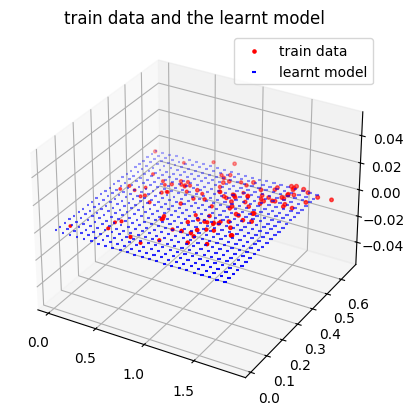

In [18]:
inTr,outTr,inTe,outTe = impartire(inputs2,outputs)

print(inTr)

inTr1 = []
inTr2 = []
for el in inTr:
    inTr1.append(el[0])
    inTr2.append(el[1])


plot3Ddata(inTr1, inTr2, outTr, xref1, xref2, yref, title='train data and the learnt model')


In [19]:
regressor = linear_model.SGDRegressor(alpha = 0.01,max_iter=100)

inputs2 = [[e1,e2] for e1,e2 in zip(normd[0],normd[1])]

regressor.fit(inputs2,normd[2])
w0,w1,w2 = regressor.intercept_[0], regressor.coef_[0], regressor.coef_[1]
print('tool: f(x) = ', w0, '+', w1, '* x1 +', w2, '* x2')

noOfPoints = 25
xref1 = []
val = min(normd[0])
step1 = (max(normd[0]) - min(normd[0])) / noOfPoints
for _ in range(1, noOfPoints):
    for _ in range(1, noOfPoints):
        xref1.append(val)
    val += step1

xref2 = []
val = min(normd[1])
step2 = (max(normd[1]) - min(normd[1])) / noOfPoints
for _ in range(1, noOfPoints):
    aux = val
    for _ in range(1, noOfPoints):
        xref2.append(aux)
        aux += step2
yref = [w0 + w1 * el1 + w2 * el2 for el1, el2 in zip(xref1, xref2)]
#plot3Ddata(normd[0], normd[1], normd[2], xref1, xref2, yref, title='train data and the learnt model')

#tool: f(x) =  4.238161532456214 + 0.9906162449565813 * x1 + -0.7514216757635761 * x2


tool: f(x) =  -0.0005586789417585432 + 0.6693321085782717 * x1 + 0.3196985837566832 * x2
